In [30]:
import torch
import os
import matplotlib.pyplot as plt
from pathlib import Path
from monai.utils import first, set_determinism
from monai.data import DataLoader, Dataset
from load_data import get_data
from transforms import get_transforms

In [31]:
set_determinism(seed=2023)
home = Path.home().as_posix()

In [32]:
datasets = {
    "ixi": {"path": home + r"/datasets/ixi/ixi_dataset.json", "label": "sex"},
    "ukb": {"path": home + r"/datasets/ukb/ukb_dataset.json", "label": "sex"},
}
    
data = get_data(
    "ixi",
    label=datasets["ixi"]["label"],
)

data["train"] = [{"image": os.path.join(home, i["image"]), "label": i["label"]} for i in data["train"]]

pixdim = 2
img_size = (180//pixdim, 180//pixdim, 160//pixdim)

transforms = get_transforms("ixi", img_size, pixdim)

#t = LoadImaged(keys=["image"])(data[0])
#print(t)

train_dataset = Dataset(
    data=data["train"],
    transform=transforms["train"],
)

train_loader = DataLoader(
    train_dataset,
)

data_first = first(train_loader)
print(f"image shape: {data_first['image'].shape}, label shape: {data_first['label'].shape}")

image shape: torch.Size([1, 1, 90, 90, 80]), label shape: torch.Size([1])


/home/neutron/.local/lib/python3.8/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.
  warn_deprecated(argname, msg, warning_category)


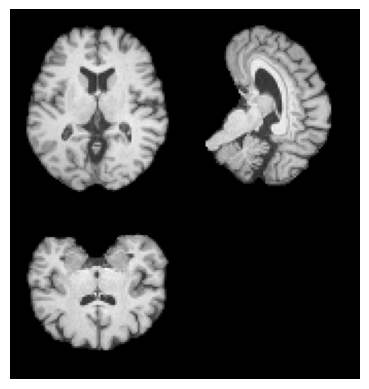

In [33]:
_, _, x, y, z = data_first["image"].shape
x_ = x//2
y_ = y//2
z_ = z//2
img1 = data_first["image"][0, 0, x_, :, :]
img2 = data_first["image"][0, 0, :, y_, :]
img3 = data_first["image"][0, 0, :, :, z_]
comb = torch.cat((img2, img3), 1)

black = torch.zeros(img1.shape[0], comb.shape[1] - img1.shape[1]) + -0.5587
comb2 = torch.cat((img1, black), 1)
combined = torch.cat((comb, comb2), 0)
fig = plt.figure()
plt.imshow(combined, cmap="gray")
plt.axis("off")  # Turn off axis labels
#plt.suptitle("Brain MRI overview", y=0.745)
#plt.savefig(r"/home/neutron/dev/thesis/src/ixi_image.png", bbox_inches='tight', pad_inches=0.0)
plt.show()